In [1]:
# Own MovieLens experiments

In [44]:
# Preprocessing
# https://petamind.com/create-bipartite-graph-from-a-rating-matrix/

from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

RANDOM = 2021

In [3]:
datasets = {
    'ml-100k': '/home/weiss/rs_data/ml-100k/',
    'ml-latest-small': '/home/weiss/rs_data/ml-latest-small/',
    'ml-latest': '/home/weiss/rs_data/ml-latest/'
}

print('Available datasets: ', [key for key in datasets])
#dt = input('Dataset name = ')
dt='ml-latest-small'
print('You selected {}'.format(dt))

Available datasets:  ['ml-100k', 'ml-latest-small', 'ml-latest']
You selected ml-latest-small


In [4]:
# Check structure
def list_files(startpath):
    print(startpath)
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
dirs = [x[0] for x in os.walk(datasets[dt])]
ml = filter(lambda dirName: dirName if ('ml' in dirName) else '', list(dirs))
dt_dir_name= list(ml)[0]
print(list_files(dt_dir_name))

/home/weiss/rs_data/ml-latest-small/
/
    links.csv
    README.txt
    ratings.csv
    movies.csv
    tags.csv
None


In [5]:
# Select ratings and tags
if dt=='ml-100k':
  ratings_data= pd.read_csv(dt_dir_name +'/'+ 'u.data', delimiter='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
  user_data= pd.read_csv(dt_dir_name +'/'+ 'u.user', delimiter='|', names=['user id', 'age' ,'gender' ,'occupation' , 'zip code'])
  ratings_data.shape
elif dt=='ml-latest-small':
  ratings_data=pd.read_csv(dt_dir_name +'/'+ 'ratings.csv')
  tag_data=pd.read_csv(dt_dir_name +'/'+ 'tags.csv')
  ratings_data.shape
elif dt=='ml-latest':
  rating_data=pd.read_csv(dt_dir_name +'/'+ 'ratings.csv')
  tag_data=pd.read_csv(dt_dir_name +'/'+ 'tags.csv')
  rating_data.shape

In [6]:
# Check data
print(ratings_data.head())
print(ratings_data.info())
print('Ratings null?\n', ratings_data.isnull().any())
if dt == 'ml-100k':
    print(user_data.head())
    print('Users null?\n', user_data.isnull().any())
if dt == 'ml-latest-small' or dt == 'ml-latest':
    print(tag_data.head())
    print('Tags null?\n', tag_data.isnull().any())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
Ratings null?
 userId       False
movieId      False
rating       False
timestamp    False
dtype: bool
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774

In [9]:
# Create Train, Test, Validation Split (80/10/10)
# for original ratings

rX_train, rX_test = train_test_split(ratings_data[['userId', 'movieId', 'rating']], test_size=0.2, random_state = RANDOM)
rX_train, rX_val = train_test_split(rX_train, test_size=0.5, random_state = RANDOM)
print(rX_train.shape, rX_test.shape, rX_val.shape)

(40334, 3) (20168, 3) (40334, 3)


In [13]:
def save_to_csv(data_frames, out_file_names, outdir=dt_dir_name+'processed/'):
    """
    Save Train, Test, Validation Split to csv files
    """
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    assert len(data_frames)==len(out_file_names), "number of dataframes must equal number of file names"
    for i in range(len(out_file_names)):
        data_frames[i].to_csv(outdir+out_file_names[i], header=None, index=False)

In [20]:
# Check negative sampling train dataset
rX_train.head()

# Save train, test, validation to CSV
save_to_csv([rX_train, rX_test, rX_val], ['rX_train.csv', 'rX_test.csv', 'rX_val.csv'] )

In [15]:
# Negative Sampling
import random
import time

def negative_sampling(r):
    """
    Create negative samples, i.e. user-movie combinations with no ratings
    
    Parameters:
    input rating data -- pd dataframe: userId, movieId, rating
    
    Returns:
    negative sampled set -- pd dataframe: uderId, movieId, interact (implicit)
    """
    users = r['userId'].drop_duplicates()  # get unique userIds
    movies = r['movieId'].drop_duplicates()  # get unique movieIds
    print('# users', len(users))
    print('# movies', len(movies))
    negative_samples = r[['userId', 'movieId', 'timestamp']]  # starting point
    negative_samples['interact'] = negative_samples.apply(lambda row: 1, axis=1)
    negative_tmp_data = []  # lsit to craft interaction [userId, movieId, timestamp, interaction]
    start_time = time.time()
    stop_time = time.time()
    for i, row in r.iterrows():
        user = row['userId']  # current user
        if (i%500==0):
            stop_time = time.time()
            print('user {}', user, 'processed ... {0:0.2f}% after {1:0.2f} sec'.format(((i)*100.0 / len(r)), stop_time - start_time))
        j = 1  # amount of negative samples
        while j > 0:
            movie = movies.sample(n=1).values[0]  # get random movieId
            # insert negative samples if u-m relation does not exist
            if (not((negative_samples['userId'] == user)
                    & (negative_samples['movieId'] == movie)).any()):
                j -= 1
                negative_tmp_data.append([user, movie, int(time.time()), -1])
        negative_temp_df = pd.DataFrame(data=negative_tmp_data, columns=['userId', 'movieId', 'timestamp', 'interact'])
        negative_samples = pd.concat([negative_samples, negative_temp_df], ignore_index=True)
    return negative_samples

#ns = negative_sampling(ratings_data)
#print(ns.head())

# Create Train, Test, Validation Split (80/10/10)
# for negative samples
#rX_train_ns, rX_test_ns = train_test_split(ns, test_size=0.2, random_state = RANDOM)
#rX_train_ns, rX_val_ns = train_test_split(rX_train_ns, test_size=0.5, random_state= RANDOM)
#print(rX_train_ns.shape, rX_test_ns.shape, rX_val_ns.shape)

# Check negative sampling train dataset
#rX_train_ns.head()

# Save negative sampling datasets
#save_to_csv([rX_train_ns, rX_test_ns, rX_val_ns], ['rX_train_ns.csv', 'rX_test_ns.csv', 'rX_val_ns.csv'] )

In [31]:
# read data from CSV
rX_train = pd.read_csv(dt_dir_name + 'processed/' + 'rX_train.csv', names=['userId', 'movieId', 'rating'])
rX_test = pd.read_csv(dt_dir_name + 'processed/' + 'rX_test.csv', names=['userId', 'movieId', 'rating'])
rX_val = pd.read_csv(dt_dir_name + 'processed/' + 'rX_val.csv', names=['userId', 'movieId', 'rating'])


rX_train['userId'] = 'u' + rX_train['userId'].astype(str)
rX_train['movieId'] = 'i' + rX_train['movieId'].astype(str)
rX_train.head()

,userId,movieId,rating
0,u125,i166635,4.0
1,u190,i5989,4.0
2,u22,i59315,0.5
3,u294,i1089,3.0
4,u56,i292,4.0


In [37]:
import networkx as nx
from networkx import *
 
#Create a graph
G = nx.Graph()
 
#Add nodes
G.add_nodes_from(rX_train.userId, bipartite=0)
G.add_nodes_from(rX_train.movieId, bipartite=1)
 
#Add weights (ratings) for edges
G.add_weighted_edges_from([(userId, movieId, rating) for (userId, movieId, rating) 
              in rX_train[['userId', 'movieId', 'rating']].to_numpy()])

print(info(G))
G.is_directed(), G.is_multigraph(), is_bipartite(G)
#(False, False, True)

# Vers slow analysis
#print("radius: %d" % radius(G))
#radius: 3
 
#print("diameter: %d" % diameter(G))
#diameter: 5
 
#print("eccentricity: %s" % eccentricity(G))
#eccentricity: {'u196': 4, 'u186': 4, 'u22': 4,...}
 
#print("center: %s" % center(G))
#center: ['u6', 'u62', 'u286', 'u200', 'u303',...]
 
#print("periphery: %s" % periphery(G))
#periphery: ['u50', 'u97', 'u284', 'u242',...]
 
#print("density: %s" % density(G))
#density: 0.029036004645760744

Name: 
Type: Graph
Number of nodes: 7522
Number of edges: 40333
Average degree:  10.7240


(False, False, True)

In [40]:
import networkx as nx
from networkx import *
 
# Create a graph
G = nx.Graph()
 
# Add nodes
G.add_nodes_from(rX_train.userId, bipartite=0)
G.add_nodes_from(rX_train.movieId, bipartite=1)
 
# Add weights (ratings) for edges
G.add_weighted_edges_from([(userId, movieId, rating) for (userId, movieId, rating) 
              in rX_train[['userId', 'movieId', 'rating']].to_numpy()])


In [41]:
color_map = []
for node in G.nodes:
  if str(node).startswith('u'):
    color_map.append('yellow')
  else:
    color_map.append('green')

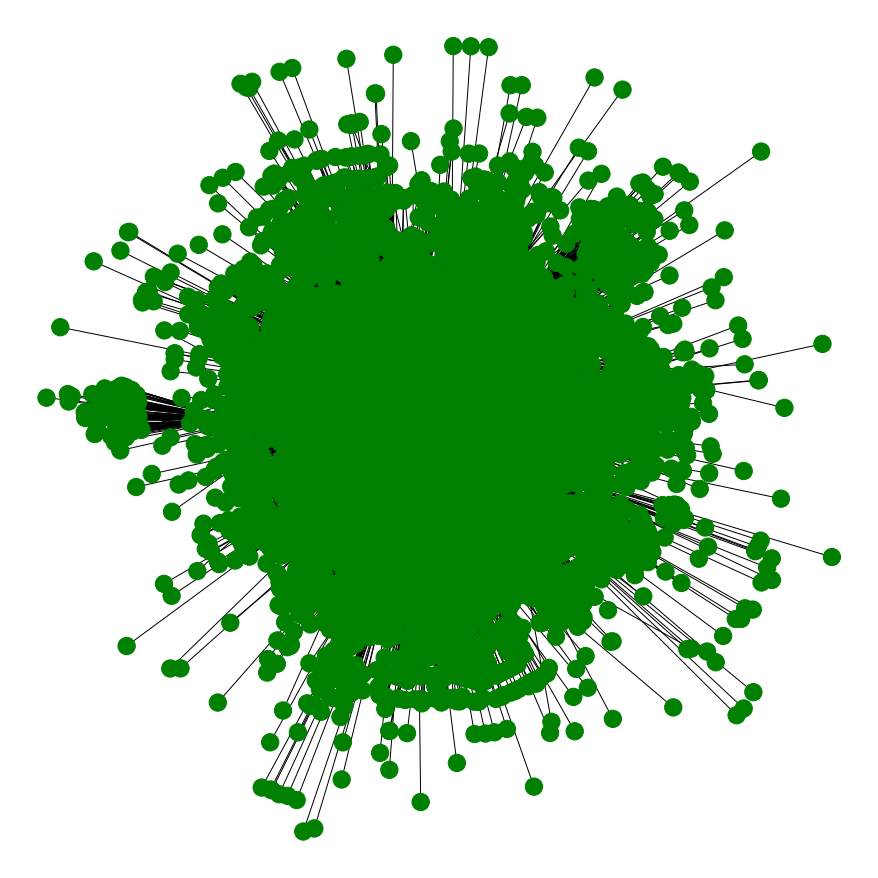

In [45]:
pos = nx.spring_layout(G)
plt.figure(3,figsize=(12,12)) 
nx.draw(G,pos,node_color=color_map)
plt.show()

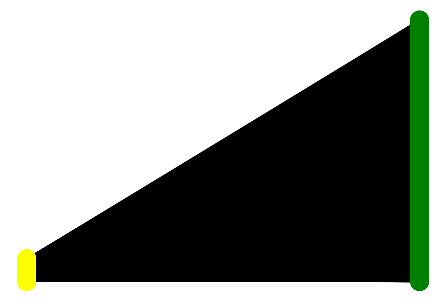

In [46]:
X, Y = bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(G, pos=pos, node_color=color_map)
plt.show()